## Semester 1 Project Submission

Please fill out:
* Student name: 
* Instructor name: 


In [ ]:
# Your code here - remember to use markdown cells for comments as well!

In [ ]:
### Relevant Imports ###
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile

%matplotlib inline

# Business Understanding

### Business Understanding

Computing Vision (a made-up company for the purposes of this project) sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t have much background in creating movies. You are charged with exploring what types of films are currently doing the best at the box office using different samples of available data. You then will translate those findings into actionable insights that the head of Computing Vision's new movie studio can use to help decide what type of films to create.

### Business Metrics

Our recommendations for this company will be based off of the Gross Margin which is portrayed as a percentage. The higher this percentage is the more the company is retaining for every dollar that is invested in the movie and as such is seeing a higher return on their investment.

$Gross Margin = \frac{Gross Revenue - Costs}{Gross Revenue} x 100$

This is an important metric, especially for a company about to enter an industry they have no presence in because it will help show how far their money goes to create profit. The higher this percentage the better the business will be doing because it is an indicator that retains more on each dollar of sales to its costs. This metric also allows us to take a standardized approach to comparing movies and their success. 

We want to investigate what a "Good Movie" i.e. a movie with a high Gross Margin is doing and try to emulate that. Thus we will explore the budget size, what directors are involved in those high margin films, and also what genres see the highest margin

# Data Understanding
### Opening all zipped files and databases

We began our exploring our data by unzipping the SQLite database as well as reading in all of out csv/tsv files into pandas data frames to get a better idea of how we can approach cleaning the data

In [ ]:
# open an sqlite connection

conn = sqlite3.connect("zippedData/im.db")
cur = conn.cursor()

In [ ]:
# Pull all of the tables in the database
cur.execute("""SELECT name FROM sqlite_master WHERE type = 'table';""")
# Fetch the result and store it in table_names
table_names = cur.fetchall()
table_names

In [ ]:
# query the notable tables movie_basics
q1 = """
SELECT *
FROM movie_basics
LIMIT 5;
"""
pd.read_sql(q1, conn)

In [ ]:
# query the notable tables movie_ratings
q2 = """
SELECT *
FROM movie_ratings
LIMIT 5;
"""
pd.read_sql(q2, conn)

### Database information

These two database tables share a "movie_id" column, thus we can join on this key and take a look at movie information including name, release year, and genre as well as the average rating with the number of votes. We want to find a good balance of average rating as well as number of ratings since a small number of really high ratings could skew the interpretation of what a "good" movie is.

### CSV and TSV file information

Read in all of the tsv and csv files in the proper formatting ensuring headers and proper indexing for the ones which require it as well as proper encoding for the tsv files

In [ ]:
movie_info = pd.read_csv("zippedData/rt.movie_info.tsv",header = 0, sep = '\t')    

reviews = pd.read_csv("zippedData/rt.reviews.tsv", header = 0, sep = '\t', encoding= 'unicode_escape')

tmdb_movies = pd.read_csv("zippedData/tmdb.movies.csv", header = 0)    

movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv", header = 0)

movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv", header = 0)

#### Movie Info Dataframe

This dataframe contains general information regarding the movies including rating, director, release date for theaters and DVD as well as the currency, box office, runtime and studio. There is a unique id column which we will not use as an index because it could be useful for combining data frames or doing different lookups

We may consider dropping currency, box office, and studio due to there being many missing values

Most columns are missing values and as such we will have to fill or deal with those missing values accordingly, this dataframe is related to the reviews data frame by the id column which relates to a unique id for each movie

In [ ]:
movie_info.info()

In [ ]:
movie_info.head()

#### Review Dataframe

The most important information from this dataframe will be the id which cooresponds to the movie that they are reviewing and the rating that they give it. We are missing about more than 10,000 ratings which is a considerable amount to discard, so we could fill these with the average value of the rating for the movie that they are reviewing. In order to make thge rating a useful variable we would have to apply a function to transform it from a string into a float rating value

A more advanced approach would be to conduct sentiment analysis and apply weights to the most common keywords found in a review at each score level and develop a heuristic to apply a score to the missing values based on the review that they left discarding all review entries without an actual review.

This data frame has a relation to the movie_info data frame since bothg come from rotten tomatoes. The id relates to the movie that each critic leaves a review for. 

In [ ]:
reviews.info()

In [ ]:
reviews.head()

In [12]:
reviews['rating'].value_counts()

3/5       4327
4/5       3672
3/4       3577
2/5       3160
2/4       2712
          ... 
4.0          1
1.8          1
4.1/10       1
F-           1
4.0/10       1
Name: rating, Length: 186, dtype: int64

#### The Movie DB Dataframe

This dataframe is not missing any values. It has information about genre ids and contains a unique id column along with the movie name, how many votes it received, and what the average vote value was. Vote seems to be this specific sites way of ranking the movies. 

In [ ]:
tmdb_movies.info()

In [ ]:
tmdb_movies.head()

In [ ]:
# Create a dictionary to relate the genre id's to the genre found on the movie DB website at 
# this customer support url: https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee
tmbd_genres = {28: "Action", 12: "Adventure", 16: "Animation", 35: "Comedy", 99: "Documentary", 18: "Drama", 10751: "Family", 14: "Fantasy", 36: "History", 27: "Horror", 10402: "Music", 9648: "Mystery", 10749: "Romance", 878: "Science Fiction", 10770: "TV Movie", 53: "Thriller", 10752: "War", 37: "Western"}

#### Moview Budgets Data Frame

This data frame is also not missing any values, it contains an ID for each movie, the title, production budget, how much the movie grossed domestically and how much it grossed worldwide

We will be transforming this data by making the budget and gross column integers as well as adding additional columns for profit and Gross Margin to help us in later analysis

In [ ]:
movie_budgets.info()

In [ ]:
movie_budgets.head()

#### Movie Gross Data Frame

This data frame is missing a lot of foreign gross values which could potentially be filled in by taking the difference from the budgets df ww_gross - domestic_gross, otherwise we will throw out those values because we can not estimate them.

An alternative that we will not explore is scraping the web with the name of the movie and pulling in the foreign gross numbers. We are missing a few domestic gross numbers which can be thrown away since there are not many of them or we can use the movie budgets dataframe again to fill those in. 

We most likely will not use this data frame because the movie_budgets dataframe offer the same information and a bit more that is helpful to our analysis

In [ ]:
movie_gross.info()

In [ ]:
movie_gross.head()

# Data Preparation

### Data Cleaning for movie_budgets DataFrame

The money_clean function we created removes the '$' and comma symbols from the input string. We used this function to clean the production_budget, domestic_gross, and worldwide_gross columns.

In [ ]:
# This is the column of budgets which we want to investigate - notice formatting problems
prod_budget = movie_budgets["production_budget"]
prod_budget

In [ ]:
def money_clean(s):
    ''' 
    Takes in a string s, removes first character ($) and
    all commas return the value cast as an int
    '''
    s = s[1:]
    s = s.replace(",", "")
    return int(s)

# apply the method to the pandas series of budget values
prod_budget = prod_budget.apply(money_clean)

In [ ]:
# Set this cleaned series to the budget column in the data frame
movie_budgets["production_budget"] = prod_budget

# apply the function to the other money columns
movie_budgets["domestic_gross"] = movie_budgets["domestic_gross"].apply(money_clean)
movie_budgets["worldwide_gross"] = movie_budgets["worldwide_gross"].apply(money_clean)

# Calculate new values for foreign gross 
movie_budgets["foreign_gross"] = movie_budgets["worldwide_gross"] - movie_budgets["domestic_gross"]

# calculate the profit by taking gross minus budget (Revenue - cost)
movie_budgets["domestic_profit"] = movie_budgets["domestic_gross"] - movie_budgets["production_budget"]
movie_budgets["foreign_profit"] = movie_budgets["foreign_gross"] - movie_budgets["production_budget"]
movie_budgets["total_profit"] = movie_budgets["worldwide_gross"] - movie_budgets["production_budget"]

In [ ]:
# create new month and year columns for later analysis
rel_date = movie_budgets["release_date"].str.strip()

month = rel_date.apply(lambda x : x[:3])
year = rel_date.apply(lambda x : x[-4:])

movie_budgets["month"] = month
movie_budgets["year"] = year

In [ ]:
movie_budgets.head()

# Exploratory Data Analysis and Visualization

## Mason Batchelor

##### Mason works only in this section and makes No changes to any other



### Analyzing Movie Budgets

Within the movie budgets data frame we created new column to represent the profit, month, and year for each of the entries. We are going to look at the relationship between many of these variables below. 

Adding in a Gross Margin column is essential given this is the metric we are most interested in. We will use this first to analyze the differnce in budgets, and recommend whether the company should target a large or small budget film. We are going to be taking a sample of 100 movies from the movie_budgets data frame to help with our analysis and visualizations. 

Additional Assumptions:
- only consider movies with a Gross value (worldwide, domestic, and foreign) greater than zero because you cannot calculate Gross Margin with 0 gross revenue
- randome samples from this data frame are representative of the population, and will be used in a independent two sample ttest
- only consider movies with gross margin > -100 to remove outliers and aid in visualizations

In [ ]:
import math

In [ ]:
dates = pd.to_datetime(movie_budgets['release_date'])
months = dates.dt.month
movie_budgets['month_index'] = months

In [ ]:
# Create the Gross Margin column in a new dataframe called budgets
budgets =  movie_budgets.copy()

In [ ]:
# only use movies that gross > 0 (denominator cannot be 0)
budgets = budgets.loc[budgets['worldwide_gross'] > 0]

# calculate gross Margin
budgets['gross_margin_ww'] = (budgets['worldwide_gross'] - 
                              budgets['production_budget']) / budgets['worldwide_gross'] * 100

In [ ]:
# REMOVE OUTLIERS from data frame
Q1 = budgets['gross_margin_ww'].quantile(.25)
Q3 = budgets['gross_margin_ww'].quantile(.75)
IQR = Q3 - Q1
# query out the outliers in the budgets data frame which are 1.5 x the iqr
filtered_budgets = budgets.query('(@Q1 - 1.5 * @IQR) <= gross_margin_ww <= (@Q3 + 1.5 * @IQR)')

# Ploting the result to check the difference 
budgets.join(filtered_budgets, rsuffix='_filtered').boxplot(['gross_margin_ww_filtered']);

In [ ]:
filtered_budgets.loc[:, 'gross_margin_dom'] = (filtered_budgets['domestic_gross'] - 
                                        filtered_budgets['production_budget']) / filtered_budgets['domestic_gross'] * 100
filtered_budgets.loc[:, 'gross_margin_for'] = (filtered_budgets['foreign_gross'] - 
                                        filtered_budgets['production_budget']) / filtered_budgets['foreign_gross'] * 100

filtered_budgets.loc[:, 'gross_margin_for'] = filtered_budgets.loc[:, 'gross_margin_for'].apply(
    lambda x: np.NAN if ((x == -np.inf) or (x == np.inf)) else x)

filtered_budgets.loc[:, 'gross_margin_dom'] = filtered_budgets.loc[:, 'gross_margin_dom'].apply(
    lambda x: np.NAN if ((x == -np.inf) or (x == np.inf)) else x)

Now that we have all of the movies gross margin, and have removed any outliers that may skew the data related to budget we can move on with our analysis. Next we want to look at assigning a value of 1, 2, or 3 to each of the movies indicating whether or not they are small, medium, or big budget films. 

Through research we found the following:
- Less than \\$5,000,000 is considered small budget
- Between \\$5,000,000 and \\$100,000,000 is considered medium budget
- greater than \$100,000,000 is considered big budget

In [ ]:
def budget_size(val): 
    ''' This function takes in a budget int value and returns a category'''
    if val < 5000000:
        return 1
    elif val < 100000000:
        return 2
    else:
        return 3

In [ ]:
# Create budget size categorical variable to analyze differences between them
filtered_budgets.loc[:, 'budget_size'] = filtered_budgets.loc[:, 'production_budget'].apply(budget_size)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ['Small', 'Medium', 'Big']
agg_margin = filtered_budgets.groupby('budget_size')['gross_margin_ww'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin (in %)", fontsize=16)
ax.set_xlabel("Budget Size", fontsize = 16)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])

ax.set_title("Average Gross Margin for each budget size category", fontsize = 18)
plt.tight_layout();

In [ ]:
budget_size_means = filtered_budgets.groupby('budget_size')['gross_margin_ww'].mean()
budget_size_stds = filtered_budgets.groupby('budget_size')['gross_margin_ww'].std()
budget_size_val_cnts = filtered_budgets.groupby('budget_size')['gross_margin_ww'].count()

mean1 = budget_size_means[1]
std1 = budget_size_stds[1]
nobs1 = budget_size_val_cnts[1]
mean2 = budget_size_means[3]
std2 = budget_size_stds[3]
nobs2 =  budget_size_val_cnts[3]

# hyopothesis test for the mean gross margin of small and big budget films
stats.ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2)

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ['Small', 'Medium', 'Big']
agg_margin = filtered_budgets.loc[filtered_budgets['gross_margin_dom'].notna() & 
                                  (filtered_budgets['domestic_gross'] > 0)].groupby(
                                    'budget_size')['gross_margin_dom'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin (in %)", fontsize=16)
ax.set_xlabel("Budget Size", fontsize = 16)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])

ax.set_title("Average Gross Margin for Domestic by budget size", fontsize = 18)
plt.tight_layout();

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ['Small', 'Medium', 'Big']
agg_margin = filtered_budgets.loc[filtered_budgets['gross_margin_for'].notna()].groupby(
    'budget_size')['gross_margin_for'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin (in %)", fontsize=16)
ax.set_xlabel("Budget Size", fontsize = 16)
vals = ax.get_yticks()
ax.set_yticklabels([f'{x:.2f}%' for x in vals])

ax.set_title("Average Gross Margin for Foreign by budget size", fontsize = 18)
plt.tight_layout();

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = ['Small', 'Medium', 'Big']
agg_profit = filtered_budgets.groupby('budget_size')['total_profit'].mean()

sns.barplot(x=x_values, y = agg_profit.values)
ax.set_ylabel("Average Total Profit (in $)", fontsize=16)
ax.set_xlabel("Budget Size", fontsize = 16)
vals = ax.get_yticks()
ax.set_yticklabels([f'${x:,.0f}' for x in vals])

ax.set_title("Average Total Profit for each budget size category", fontsize = 18)
plt.tight_layout();

In [ ]:
# Create the Gross Margin column in a new dataframe called budgets
budgets_dom =  movie_budgets.copy()

# only use movies that gross > 0
budgets_dom = budgets_dom.loc[budgets_dom['domestic_gross'] > 0]
# calculate gross Margin
budgets_dom['gross_margin_dom'] = (budgets_dom['domestic_gross'] - 
                              budgets_dom['production_budget']) / budgets_dom['domestic_gross'] * 100
# Add month index column to budgets
month = pd.to_datetime(budgets_dom['release_date']).dt.month
budgets_dom['month_index'] = month

In [ ]:
# Create the Gross Margin column in a new dataframe called budgets
budgets_for =  movie_budgets.copy()

# only use movies that gross > 0
budgets_for = budgets_for.loc[budgets_for['foreign_gross'] > 0]
# calculate gross Margin
budgets_for['gross_margin_for'] = (budgets_for['foreign_gross'] - 
                              budgets_for['production_budget']) / budgets_for['foreign_gross'] * 100
# Add month index column to budgets
month = pd.to_datetime(budgets_for['release_date']).dt.month
budgets_for['month_index'] = month

In [ ]:
# take a random sample of size 100


sample_ww = filtered_budgets.sample(n=250) # .loc[budgets['gross_margin_ww'] > -100]
sample_dom = filtered_budgets.sample(n=250) # .loc[budgets_dom['gross_margin_dom'] > -100]
sample_for = filtered_budgets.sample(n=250) # .loc[budgets_for['gross_margin_for'] > -100]
# 

In [ ]:
# This plot is visualizing the WORLDWIDE profit margin calculated using worldwide gross
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(10,10), ncols = 2, nrows = 3)
sns.regplot(data = sample_ww, x = "gross_margin_ww" , y = "worldwide_gross", ax=ax[0,0]);
sns.regplot(data = sample_ww, x = "gross_margin_ww" , y = "production_budget", ax=ax[0,1]);

sns.regplot(data = sample_dom, x = "gross_margin_dom" , y = "domestic_gross", ax=ax[1,0]);
sns.regplot(data = sample_dom, x = "gross_margin_dom" , y = "production_budget", ax=ax[1,1]);

sns.regplot(data = sample_for, x = "gross_margin_for" , y = "foreign_gross", ax=ax[2,0]);
sns.regplot(data = sample_for, x = "gross_margin_for" , y = "production_budget", ax=ax[2,1]);

#ax1.set_title("Worldwide gross and profit margin (billion)")
#ax2.set_title("Production Budget and profit margin (hundred millions)")
plt.tight_layout();

In [ ]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(10,10), ncols = 2, nrows = 3)
sns.regplot(data = filtered_budgets, x = "gross_margin_ww" , y = "worldwide_gross", ax=ax[0,0]);
sns.regplot(data = filtered_budgets, x = "gross_margin_ww" , y = "production_budget", ax=ax[0,1]);

For high budget movies make sure to keep in mind the international audience because as the budget increases profits domestically trend downward however on the international audience profits trend upwards. If you are focusing on a low budget movie to enter into the movie industry then the focus should be domestic because profits tend to be higher comapred to international movies

In [ ]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data = sample, x = "production_budget" , y = "domestic_profit", ax=ax);

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data = sample, x = "production_budget" , y = "foreign_profit", ax=ax);

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(data = sample, x = "production_budget" , y = "total_profit", ax=ax);

Use the median gross margin

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = filtered_budgets.sort_values('month_index')['month'].unique()
agg_margin = filtered_budgets.groupby('month_index')['gross_margin_ww'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin")
ax.set_title("Average Gross Margin for each month");

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = budgets.sort_values('month_index')['month'].unique()
agg_margin = budgets.groupby('month_index')['gross_margin_ww'].mean()

sns.barplot(x=x_values, y = agg_margin.values)
ax.set_ylabel("Average Gross Margin")
ax.set_title("Average Gross Margin for each month");

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# get the month values and aggregate gross margin to plot
x_values = movie_budgets.sort_values('month_index')['month'].unique()
agg_profit = movie_budgets.groupby('month_index')['total_profit'].mean()

sns.barplot(x=x_values, y = agg_profit.values)
ax.set_ylabel("Average Total Profit")
ax.set_title("Average Total Profit for each month");

These graphs do not have aggregate values and are not being used in the current analysis

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,8), nrows = 2)
sns.barplot(data = sample.sort_values('month_index'), 
            x = 'month', 
            y='total_profit', 
            ax = ax1, 
            errwidth=0)
sns.barplot(data = movie_budgets.sort_values('month_index'), 
            x = 'month', 
            y='total_profit', 
            ax=ax2, 
            errwidth=0)

ax1.set_title("100 sample movie most profitable months")
ax2.set_title("All movies most profitable months")
plt.tight_layout()

## Maninder Bawa

##### Maninder works only in this section and makes No changes to any other


## Jessica Pasquesi

##### Jessica works only in this section and makes No changes to any other


In [25]:
q1 = """
SELECT AVG(averagerating), AVG(numvotes), min(numvotes), max(numvotes)
FROM movie_basics
JOIN movie_ratings
USING (movie_id)
WHERE genres LIKE "%Action%";
"""

q2 = """
SELECT AVG(averagerating), AVG(numvotes), min(numvotes), max(numvotes)
FROM movie_basics
JOIN movie_ratings
USING (movie_id)
WHERE genres LIKE "%Drama%";
"""

q3 = """
SELECT distinct genres
FROM movie_basics
JOIN movie_ratings
USING (movie_id)
WHERE genres LIKE "%,A%";
"""

pd.read_sql(q1, conn)

,AVG(averagerating),AVG(numvotes),min(numvotes),max(numvotes)
0,5.810361,14476.48569,5,1841066


In [26]:
new_df = pd.merge(movie_info, reviews, on = 'id')

In [135]:
tmdb_budgets = pd.merge(tmdb_movies, movie_budgets, left_on = 'title', right_on = 'movie')
tmdb_budgets.sort_values(by='total_profit', ascending = False)

,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,title,vote_average,vote_count,...,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross,domestic_profit,foreign_profit,total_profit,month,year
6,6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676,...,Avatar,425000000,760507625,2776345279,2015837654,335507625,1590837654,2351345279,Dec,2009
2251,23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,...,Avengers: Infinity War,300000000,678815482,2048134200,1369318718,378815482,1069318718,1748134200,Apr,2018
1541,14193,"[28, 12, 878, 53]",135397,en,Jurassic World,20.709,2015-06-12,Jurassic World,6.6,14056,...,Jurassic World,215000000,652270625,1648854864,996584239,437270625,781584239,1433854864,Jun,2015
1546,14196,"[28, 80, 53]",168259,en,Furious 7,20.396,2015-04-03,Furious 7,7.3,6538,...,Furious 7,190000000,353007020,1518722794,1165715774,163007020,975715774,1328722794,Apr,2015
683,5179,"[878, 28, 12]",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673,...,The Avengers,225000000,623279547,1517935897,894656350,398279547,669656350,1292935897,May,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,10075,[],408852,en,The Promise,0.600,2013-10-16,The Promise,9.0,1,...,The Promise,90000000,8224288,10551417,2327129,-81775712,-87672871,-79448583,Apr,2017
1202,17560,"[36, 10749, 18]",354859,en,The Promise,10.158,2017-04-21,The Promise,7.1,195,...,The Promise,90000000,8224288,10551417,2327129,-81775712,-87672871,-79448583,Apr,2017
1203,20848,"[36, 10749, 18]",354859,en,The Promise,10.158,2017-04-21,The Promise,7.1,195,...,The Promise,90000000,8224288,10551417,2327129,-81775712,-87672871,-79448583,Apr,2017
2132,20698,"[28, 80, 14]",400106,en,Bright,15.677,2017-12-22,Bright,6.2,3181,...,Bright,90000000,0,0,0,-90000000,-90000000,-90000000,Dec,2017


In [143]:
index = 0
for row in tmdb_budgets['genre_ids']:    
    row = row.strip()
    row = row.replace("[", "")        
    row = row.replace("]", "")
    row = row.replace(" ", "")
    row = row.split(",")
    for key in tmbd_genres.keys():
        if row[0] == "":
            tmdb_budgets['genre'][index] = 'None'
        elif int(row[0]) == key:
            tmdb_budgets['genre'][index] = tmbd_genres[key]
    index+=1
                

<ipython-input-143-a2ca609371d9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmdb_budgets['genre'][index] = tmbd_genres[key]
<ipython-input-143-a2ca609371d9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmdb_budgets['genre'][index] = 'None'


In [197]:
tmdb_budgets.head()
#tmdb_budgets = tmdb_budgets.loc[tmdb_budgets['worldwide_gross']>0]

,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,title,vote_average,vote_count,...,production_budget,domestic_gross,worldwide_gross,foreign_gross,domestic_profit,foreign_profit,total_profit,month,year,genre
0,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,...,165000000,217581232,494870992,277289760,52581232,112289760,329870992,Mar,2010,Fantasy
1,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,...,170000000,312433331,621156389,308723058,142433331,138723058,451156389,May,2010,Adventure
2,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,...,30000000,191796233,364545516,172749283,161796233,142749283,334545516,Nov,1995,Animation
3,2473,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,...,30000000,191796233,364545516,172749283,161796233,142749283,334545516,Nov,1995,Animation
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,...,160000000,292576195,835524642,542948447,132576195,382948447,675524642,Jul,2010,Action


Text(0.5, 0, 'value_counts')

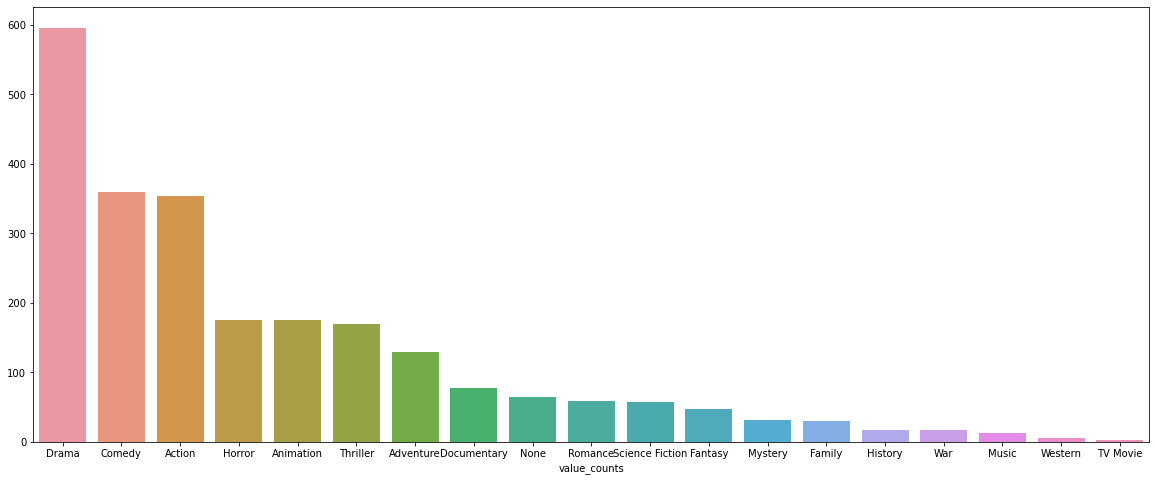

In [192]:
# value counts
tmdb_budgets['genre'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_budgets['genre'].value_counts().index.tolist()
y_values = tmdb_budgets['genre'].value_counts()

sns.barplot(x=x_values, y=y_values)
ax.set_ylabel("");

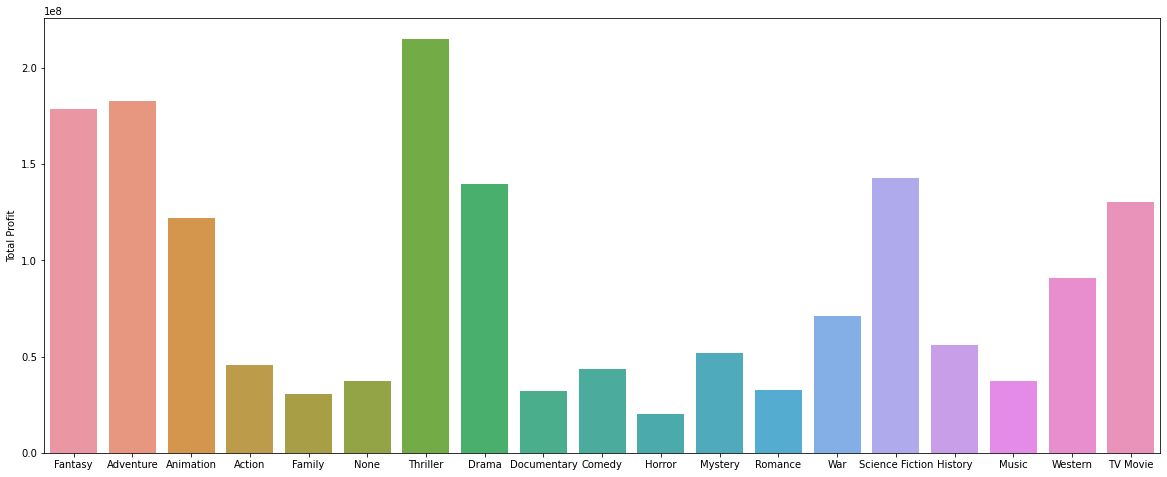

In [194]:
#genre vs average total profit
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_budgets['genre'].unique()
y_values = tmdb_budgets.groupby('genre')['total_profit'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_ylabel("");
ax.set_ylabel("Total Profit");

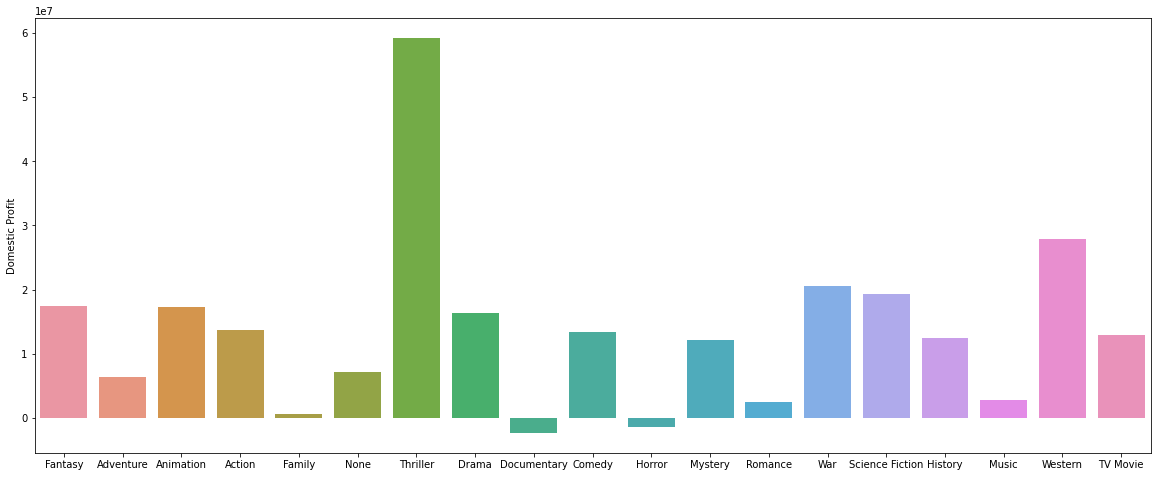

In [195]:
#genre vs average domestic profit
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_budgets['genre'].unique()
y_values = tmdb_budgets.groupby('genre')['domestic_profit'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_ylabel("");
ax.set_ylabel("Domestic Profit");

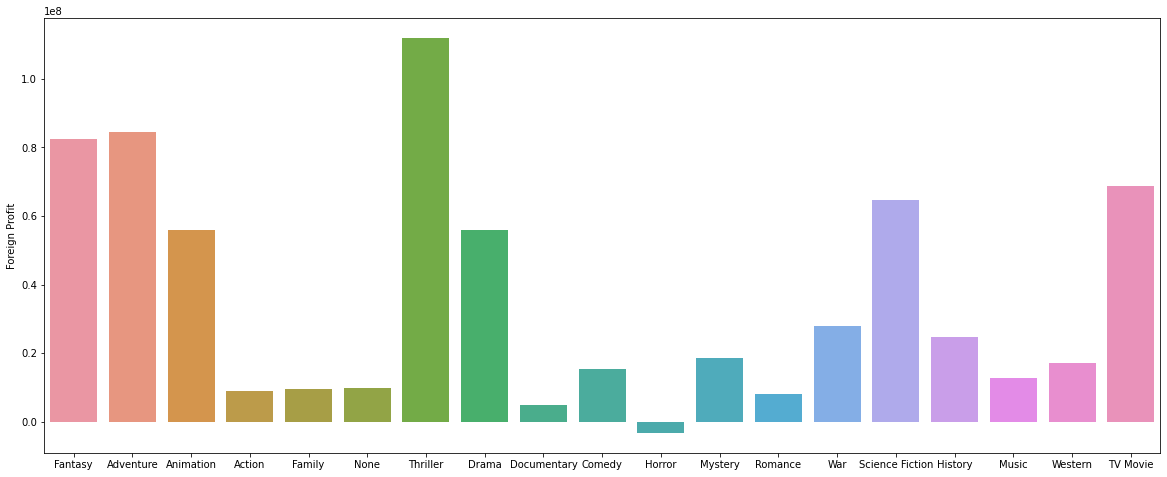

In [196]:
#genre vs average foreign profit
fig, ax = plt.subplots(figsize=(20,8))

x_values = tmdb_budgets['genre'].unique()
y_values = tmdb_budgets.groupby('genre')['foreign_profit'].mean()

sns.barplot(x=x_values, y=y_values)
ax.set_ylabel("");
ax.set_ylabel("Foreign Profit");

## Vijeet Yarlagadda

##### Vijeet works only in this section and makes No changes to any other
